In [2]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import math
import os
from keras.preprocessing import image
from keras.models import load_model
from tensorflow.keras import regularizers, losses
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, ZeroPadding2D
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import LearningRateScheduler

In [3]:
data_dir = 'D:/Animals/raw-img'

In [4]:
batch_size = 32
image_size = (224, 224, 3)
epoch_step = int(26179/batch_size)
model_name = "GoogleNet_Animals"
print(epoch_step)

818


In [5]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)


In [6]:
train_ds = train_datagen.flow_from_directory(
  data_dir,
  class_mode='categorical', subset='training',
  seed = 123,
  target_size=(image_size[0], image_size[1]),
  batch_size=batch_size)

val_ds = train_datagen.flow_from_directory(
  data_dir,
  class_mode='categorical', subset='validation',
  seed=123,
  target_size=(image_size[0], image_size[1]),
  batch_size=batch_size)

print(batch_size)

Found 20947 images belonging to 10 classes.
Found 5232 images belonging to 10 classes.
32


In [7]:
# create model
def inception(x, filters):
    path1 = Conv2D(filters=filters[0], kernel_size=(1,1), strides=1, padding='same', activation='relu')(x)
    path2 = Conv2D(filters=filters[1][0], kernel_size=(1,1), strides=1, padding='same', activation='relu')(x)
    path2 = Conv2D(filters=filters[1][1], kernel_size=(3,3), strides=1, padding='same', activation='relu')(path2)
    path3 = Conv2D(filters=filters[2][0], kernel_size=(1,1), strides=1, padding='same', activation='relu')(x)
    path3 = Conv2D(filters=filters[2][1], kernel_size=(5,5), strides=1, padding='same', activation='relu')(path3)
    path4 = MaxPooling2D(pool_size=(3,3), strides=1, padding='same')(x)
    path4 = Conv2D(filters=filters[3], kernel_size=(1,1), strides=1, padding='same', activation='relu')(path4)
    return Concatenate(axis=-1)([path1,path2,path3,path4])

In [8]:
def auxiliary(x, name=None):
    layer = AveragePooling2D(pool_size=(5,5), strides=3, padding='valid')(x)
    layer = Conv2D(filters=128, kernel_size=(1,1), strides=1, padding='same', activation='relu')(layer)
    layer = Flatten()(layer)
    layer = Dense(units=256, activation='relu')(layer)
    layer = Dropout(0.4)(layer)
    layer = Dense(units=10, activation='softmax', name=name)(layer)
    return layer

In [9]:
def googlenet():
    layer_in = Input(shape=image_size)
    layer = Conv2D(filters=64, kernel_size=(7,7), strides=2, padding='same', activation='relu')(layer_in)
    layer = MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(layer)
    layer = BatchNormalization()(layer)
    layer = Conv2D(filters=64, kernel_size=(1,1), strides=1, padding='same', activation='relu')(layer)
    layer = Conv2D(filters=192, kernel_size=(3,3), strides=1, padding='same', activation='relu')(layer)
    layer = BatchNormalization()(layer)
    layer = MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(layer)
    layer = inception(layer, [ 64,  (96,128), (16,32), 32]) 
    layer = inception(layer, [128, (128,192), (32,96), 64]) 
    layer = MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(layer)
    layer = inception(layer, [192,  (96,208),  (16,48),  64]) 
    aux1  = auxiliary(layer, name='aux1')
    layer = inception(layer, [160, (112,224),  (24,64),  64])
    layer = inception(layer, [128, (128,256),  (24,64),  64]) 
    layer = inception(layer, [112, (144,288),  (32,64),  64]) 
    aux2  = auxiliary(layer, name='aux2')
    layer = inception(layer, [256, (160,320), (32,128), 128]) 
    layer = MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(layer)
    layer = inception(layer, [256, (160,320), (32,128), 128]) 
    layer = inception(layer, [384, (192,384), (48,128), 128]) 
    layer = AveragePooling2D(pool_size=(7,7), strides=1, padding='valid')(layer)
    layer = Flatten()(layer)
    layer = Dropout(0.4)(layer)
    layer = Dense(units=256, activation='linear')(layer)
    main = Dense(units=10, activation='softmax', name='main')(layer)   
    model = Model(inputs=layer_in, outputs=[main, aux1, aux2])
    return model

In [10]:
model = googlenet()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 64  9472        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 56, 56, 64)   0           ['conv2d[0][0]']                 
                                                                                              

In [11]:
epochs = 20
initial_learning_rate = 0.01
def decay(epoch, steps=epoch_step):
 initial_learning_rate = 0.01
 drop = 0.96
 epochs_drop = 8
 learning_rate = initial_learning_rate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
 return learning_rate

sgd = SGD(initial_learning_rate, momentum=0.9, nesterov=False)
learning_scheduler = LearningRateScheduler(decay, verbose=1)

In [12]:
model.compile(loss=['categorical_crossentropy', 'categorical_crossentropy', 'categorical_crossentropy'], 
              loss_weights=[1, 0.3, 0.3], optimizer=sgd, metrics=['accuracy'])

In [ ]:
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=20,
                    batch_size=32,     
                    callbacks=[learning_scheduler])


Epoch 1: LearningRateScheduler setting learning rate to 0.01.
Epoch 1/20


In [1]:
model.save('GoogleNet_Animals')

NameError: name 'model' is not defined

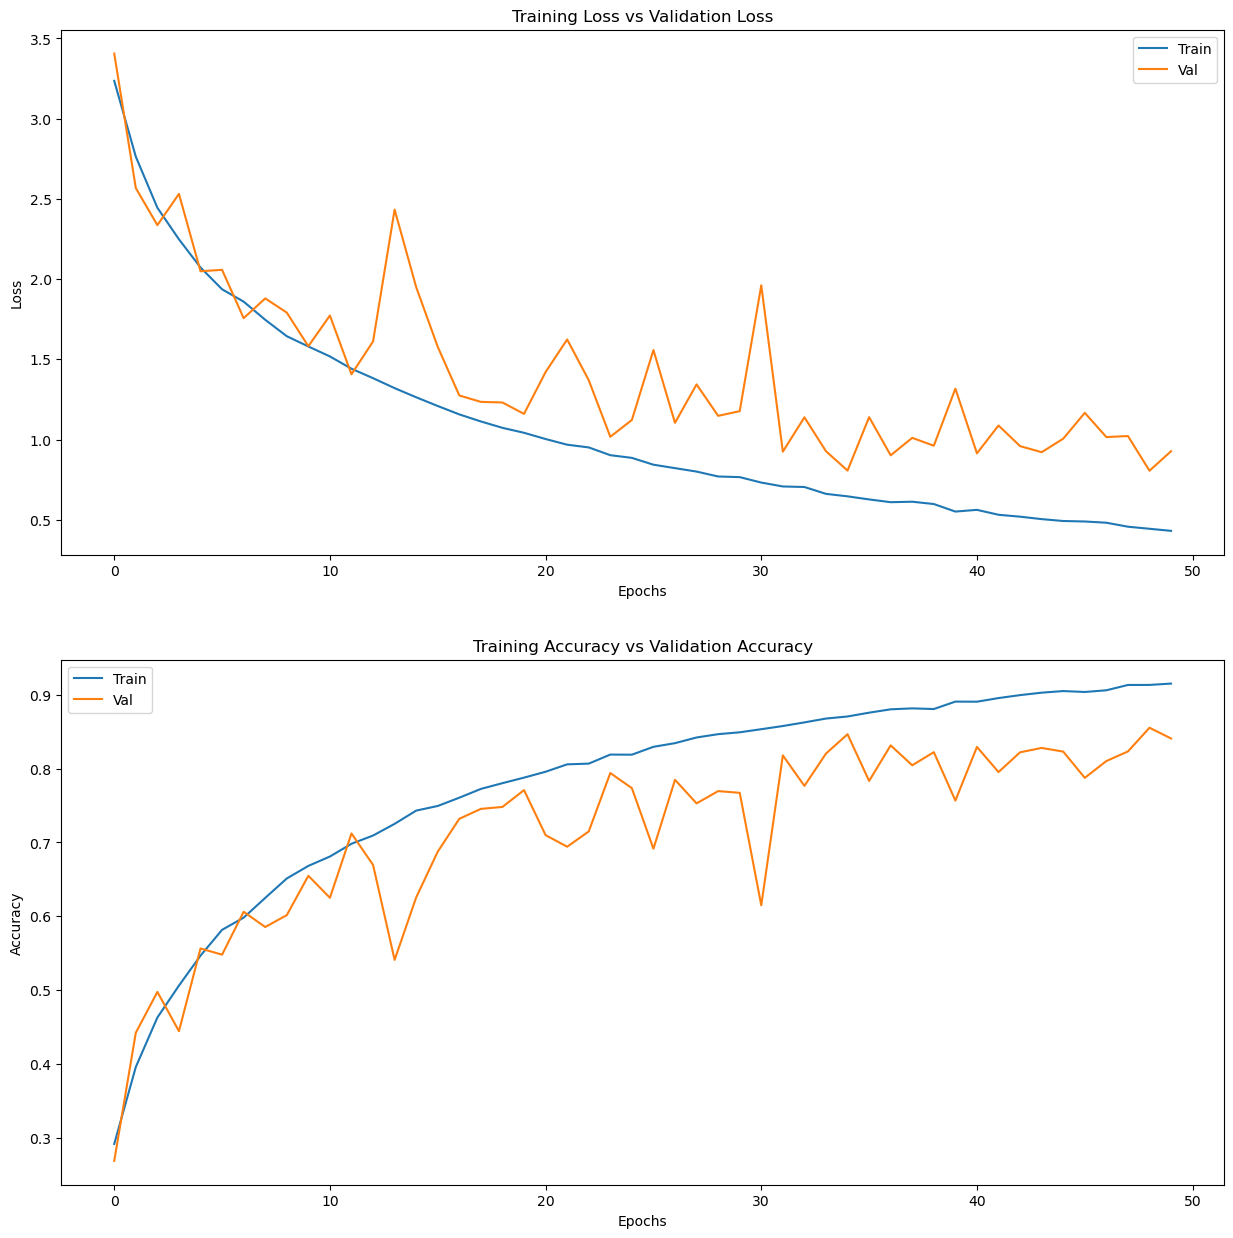

In [24]:
fig, axs = plt.subplots(2, 1, figsize=(15,15))
axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'])
axs[0].title.set_text('Training Loss vs Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend(['Train','Val'])
axs[1].plot(history.history['main_accuracy'])
axs[1].plot(history.history['val_main_accuracy'])
axs[1].title.set_text('Training Accuracy vs Validation Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend(['Train', 'Val'])